In [ ]:
# Decision Tree Hyperparameter Tuning
## Signature-Free SIEM Event Classification

#This notebook performs controlled hyperparameter tuning of a Decision Tree
#model using signature-free (behavioral) features and compares it with the
#production Logistic Regression baseline.


In [27]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report


In [28]:
df = pd.read_csv("data/raw/cyfercode_security_events_v2.csv")
df.head()


,event_type,src_ip_type,dst_port,protocol,alert_signature,failed_attempts,session_duration,bytes_sent,is_cloud_asset,alert_severity,label
0,firewall,internal,21,tcp,normal,1,66,47,1,low,0
1,cloud,internal,53,tcp,normal,5,209,2915,1,low,0
2,auth,internal,25,tcp,normal,2,677,11857,0,low,0
3,firewall,internal,3389,tcp,normal,3,53,2847,0,low,0
4,ids,internal,443,tcp,normal,3,70,2654,0,low,0


In [29]:
## Signature-Free Feature Engineering (Same as Baseline V2-B)

#All signature-based information is removed. The model relies only on
#behavioral and contextual features.


SyntaxError: invalid syntax (431120459.py, line 3)

In [30]:
df_sf = df.copy()
df_sf = df_sf.drop(columns=["alert_signature"])


In [7]:
df_sf.columns


Index(['event_type', 'src_ip_type', 'dst_port', 'protocol', 'failed_attempts',
       'session_duration', 'bytes_sent', 'is_cloud_asset', 'alert_severity',
       'label'],
      dtype='object')

In [8]:
y = df_sf["label"]

num_features = [
    "dst_port",
    "failed_attempts",
    "session_duration",
    "bytes_sent"
]

cat_features = [
    "event_type",
    "src_ip_type",
    "protocol",
    "alert_severity",
    "is_cloud_asset"
]

X = df_sf[num_features + cat_features]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [10]:
## Decision Tree Pipeline

We keep preprocessing identical to previous baselines to ensure a fair
comparison.


SyntaxError: invalid syntax (2626886070.py, line 3)

In [11]:
numeric_pipeline = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_pipeline = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_features),
        ("cat", categorical_pipeline, cat_features)
    ]
)


In [12]:
dt_model = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=42
)

param_grid = {
    "classifier__max_depth": [3, 4, 5, 6, 8, 10],
    "classifier__min_samples_leaf": [10, 25, 50, 100]
}

dt_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", dt_model)
    ]
)

grid_search = GridSearchCV(
    estimator=dt_pipeline,
    param_grid=param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['dst_port',
                                                                          'failed_attempts',
                                                                          'session_duration',
                                                                          'bytes_sent']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['event_type',
                                                                          'src_ip_type',
                                                                          'protocol',
                                                                          'alert_severity',
                                                                          'is_cloud_asset'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3, 4, 5, 6, 8, 10],
                         'classifier__min_samples_leaf': [10, 25, 50, 100]},
             scoring='recall', verbose=1)

In [13]:
grid_search.best_params_


{'classifier__max_depth': 3, 'classifier__min_samples_leaf': 10}

In [14]:
best_dt_pipeline = grid_search.best_estimator_

In [15]:
## Threshold Analysis

#We evaluate Decision Tree behavior using the same thresholds
#as the Logistic Regression baseline.


SyntaxError: invalid syntax (2430359928.py, line 3)

In [17]:
y_proba_dt = best_dt_pipeline.predict_proba(X_test)[:, 1]

thresholds = [0.9, 0.7, 0.5, 0.4, 0.3]
rows = []

for t in thresholds:
    y_pred_t = (y_proba_dt >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    rows.append({
        "threshold": t,
        "attack_recall": tp / (tp + fn),
        "false_positives": fp,
        "true_positives": tp
    })

threshold_df_dt_tuned = pd.DataFrame(rows)
threshold_df_dt_tuned


,threshold,attack_recall,false_positives,true_positives
0,0.9,0.981496,0,1220
1,0.7,0.981496,0,1220
2,0.5,1.000000,66,1243
3,0.4,1.000000,66,1243
4,0.3,1.000000,66,1243


In [18]:
SELECTED_THRESHOLD = 0.7

y_pred_dt = (y_proba_dt >= SELECTED_THRESHOLD).astype(int)

print("Tuned Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))


Tuned Decision Tree Confusion Matrix:
[[4401    0]
 [  23 1220]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4401
           1       1.00      0.98      0.99      1243

    accuracy                           1.00      5644
   macro avg       1.00      0.99      0.99      5644
weighted avg       1.00      1.00      1.00      5644



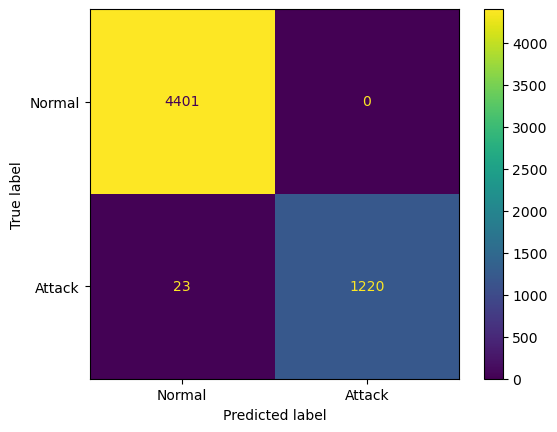

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, display_labels=["Normal", "Attack"], values_format="d")
plt.show()

In [19]:
feature_names = best_dt_pipeline.named_steps[
    "preprocessor"
].get_feature_names_out()

importances = best_dt_pipeline.named_steps[
    "classifier"
].feature_importances_

feature_importance_dt = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

feature_importance_dt.head(15)


,feature,importance
0,cat__alert_severity_low,9.882188e-01
1,num__failed_attempts,1.178120e-02
2,num__bytes_sent,7.586464e-13
3,num__dst_port,0.000000e+00
4,num__session_duration,0.000000e+00
5,cat__event_type_cloud,0.000000e+00
6,cat__event_type_firewall,0.000000e+00
7,cat__event_type_ids,0.000000e+00
8,cat__event_type_auth,0.000000e+00
9,cat__src_ip_type_external,0.000000e+00


In [20]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


In [21]:
dt_clf = best_dt_pipeline.named_steps["classifier"]


In [24]:
feature_names = best_dt_pipeline.named_steps[
    "preprocessor"
].get_feature_names_out()


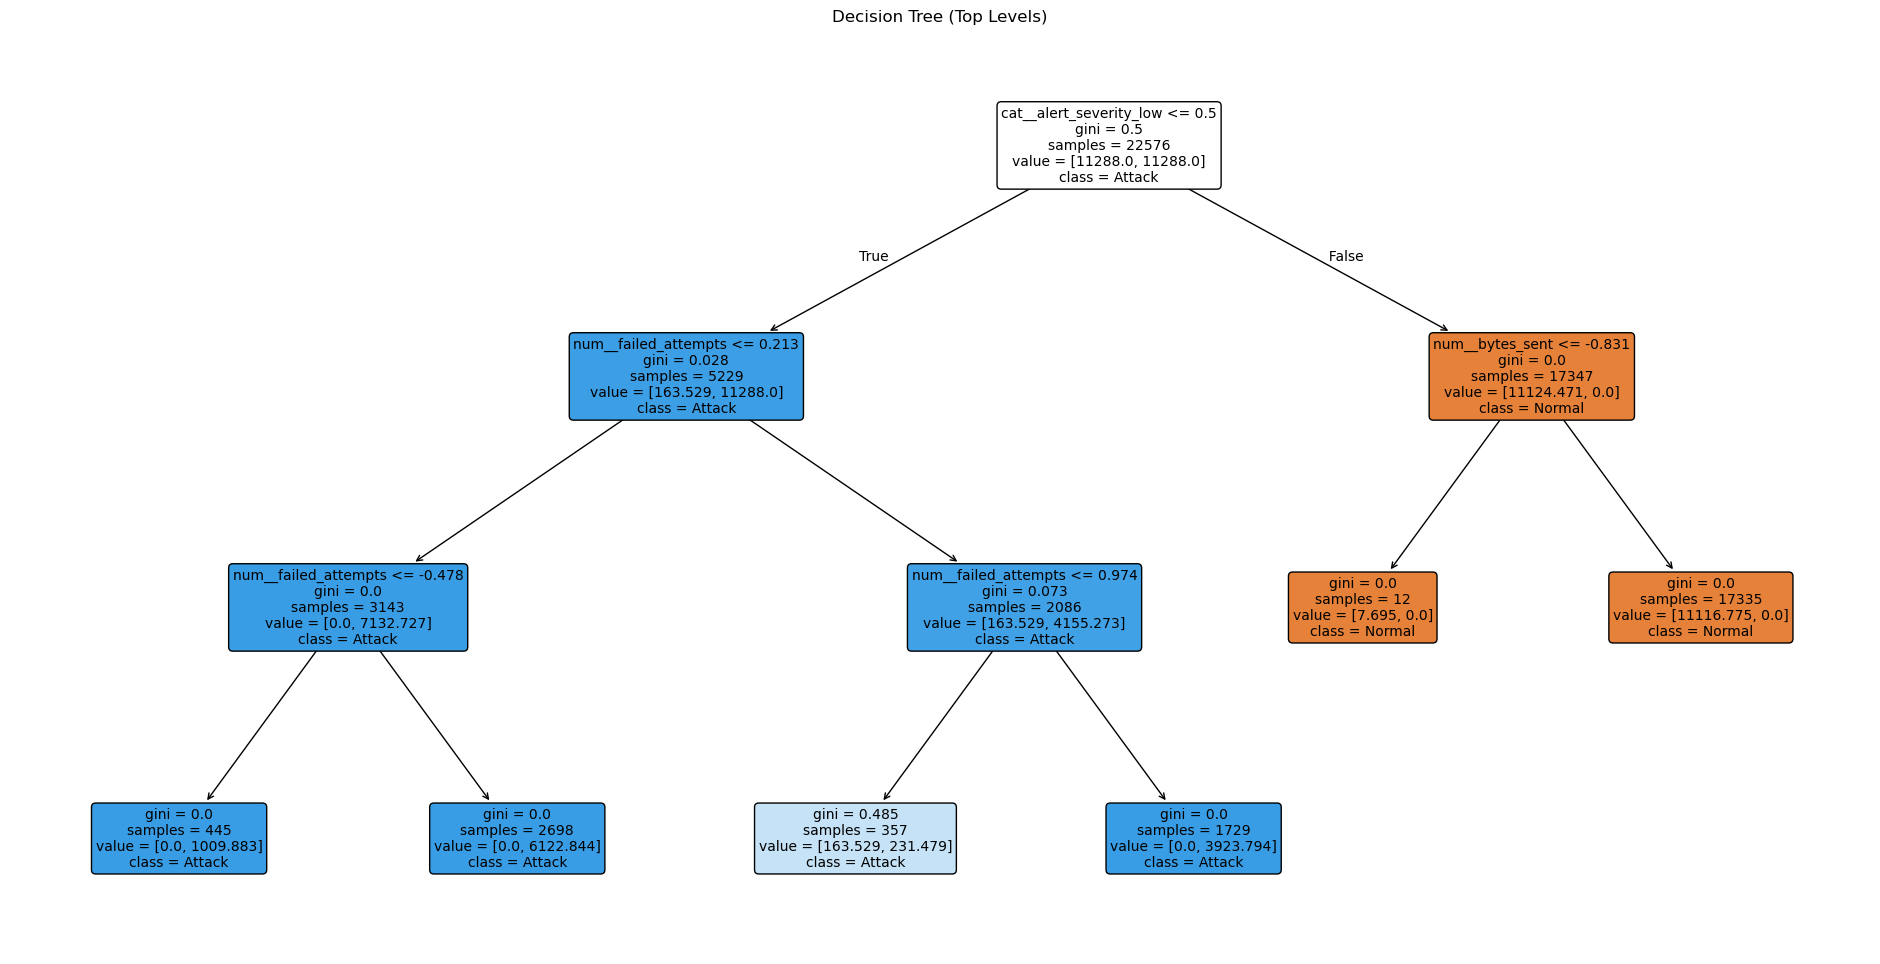

In [23]:
plt.figure(figsize=(24, 12))

plot_tree(
    dt_clf,
    feature_names=feature_names,
    class_names=["Normal", "Attack"],
    filled=True,
    rounded=True,
    max_depth=3,      # only for visualization
    fontsize=10
)

plt.title("Decision Tree (Top Levels)")
plt.show()
